In [1]:
import sys # for automation and parallelisation
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])
if manual:
    %matplotlib inline


Bad key text.latex.preview in file C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import geometry
from quetzal.model import stepmodel
from quetzal.engine import engine, connectivity
from quetzal.io import excel

# Preparation of the transport network.
## Saves access and egress links for road network
## Needs all networks.


In [3]:
input_path = '../input_static/'
output_path = '../output/'
model_path = '../model/' + scenario + '/'

In [4]:
# Load scenario parameters
params = excel.read_var(file='../input/parameters.xls', scenario=scenario)

In [5]:
sm = stepmodel.read_json(model_path + 'de_pt_network_agg')
road = stepmodel.read_json(input_path + 'de_road_network')

In [6]:
len(sm.zones)

2225

<AxesSubplot:>

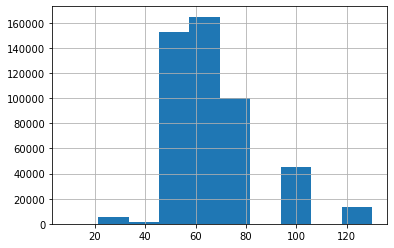

In [7]:
road.road_links['maxspeed'].hist()

## Add access and egress links from zone centroids

In [13]:
# Compute controids
sm.centroids = gpd.GeoDataFrame(sm.zones[['FID', 'NUTS_ID']],
                                geometry=gpd.points_from_xy(sm.zones['lat'], sm.zones['lon'], crs=sm.epsg),
                                crs=sm.epsg)

In [14]:
# Compute road access and egress links
sm.zone_to_road = engine.ntlegs_from_centroids_and_nodes(
    sm.centroids,
    road.road_nodes,
    short_leg_speed=params['pt_access']['speed_walk'],
    long_leg_speed=params['pt_access']['speed_bicycle'],
    threshold=params['pt_access']['catchment_radius_walk'],
    n_neighbors=params['access-egress_links']['n_road'],
    coordinates_unit=sm.coordinates_unit)
sm.zone_to_road = sm.zone_to_road.loc[
    sm.zone_to_road['distance']<=params['access-egress_links']['road_max_dist']]
sm.zone_to_road.shape

(4436, 11)

In [10]:
# Compute road - PT links
# Don't connect to bus stations
sm.road_to_transit = engine.ntlegs_from_centroids_and_nodes(
    sm.nodes.loc[sm.nodes['route_type']!='bus'],
    road.road_nodes,
    short_leg_speed=params['pt_access']['speed_walk'],
    long_leg_speed=params['pt_access']['speed_bicycle'],
    threshold=params['pt_access']['catchment_radius_walk'],
    n_neighbors=params['access-egress_links']['n_road_pt'],
    coordinates_unit=sm.coordinates_unit)
sm.road_to_transit = sm.road_to_transit.loc[
    sm.road_to_transit['distance']<=params['access-egress_links']['road_pt_max_dist']]
len(sm.road_to_transit.index)

6480

### Parametrise access and egress links

In [11]:
# Road - PT connectors
sm.road_to_transit['distance'] = 0
sm.road_to_transit['time'] = params['access-egress_links']['time_road_pt']
sm.road_to_transit.sample(n=2)

,a,b,rank,distance,geometry,direction,speed_factor,short_leg_speed,long_leg_speed,speed,time
3278,rs_DE724_0_0,4382289807,0,0,"LINESTRING (8.921399 50.82378, 8.9176888 50.82...",access,0.931934,5,17,5.0,300
91,rs_DE114_0_0,540816,0,0,LINESTRING (9.616425666666665 48.7109160000639...,access,0.572331,5,17,5.0,300


In [15]:
# Road - centroid connectors
sm.zone_to_road['distance'] = 0
sm.zone_to_road['time'] = params['access-egress_links']['time_road']
sm.zone_to_road.sample(n=2)

,a,b,rank,distance,geometry,direction,speed_factor,short_leg_speed,long_leg_speed,speed,time
3331,276786688,DE725_0,0,0,"LINESTRING (9.21825775 50.6322065, 9.2264409 5...",eggress,2.675041,5,17,13.375206,300
3818,1584536949,DEA36_5,0,0,"LINESTRING (6.964689 51.660837, 6.9666455 51.6...",eggress,0.774728,5,17,5.000000,300


## Save model

In [16]:
# Drop unneccessary columns
cols = ['speed_factor', 'short_leg_speed', 'long_leg_speed', 'rank']
sm.zone_to_road.drop(cols, axis=1, inplace=True, errors='ignore')
sm.road_to_transit.drop(cols, axis=1, inplace=True, errors='ignore')

In [17]:
# Make tables lighter
cols = ['distance', 'speed', 'time']
sm.zone_to_road[cols] = sm.zone_to_road[cols].astype(int)
sm.road_to_transit[cols] = sm.road_to_transit[cols].astype(int)

In [18]:
sm.to_json(model_path + 'de_road_access_egress',
           only_attributes=['centroids', 'zone_to_road', 'road_to_transit'],
           encoding='utf-8')

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.33it/s]
